In [1]:
from dowhy import CausalModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Generate synthetic data

In [2]:
data_size = 1000
data = pd.DataFrame({
    'AGE': np.random.randint(18, 65, data_size),
    'HEART DISEASE': np.random.randint(0, 5, data_size),
    'ASPIRIN': np.random.randint(0, 2, data_size)
})
data['STROKE'] =  np.random.randint(0,2, data_size) 
data.loc[(data['STROKE']==0)]

,AGE,HEART DISEASE,ASPIRIN,STROKE
0,50,1,1,0
2,52,1,0,0
4,28,2,1,0
6,44,3,1,0
9,28,3,0,0
...,...,...,...,...
988,41,2,0,0
992,18,2,1,0
993,32,0,0,0
995,30,0,0,0


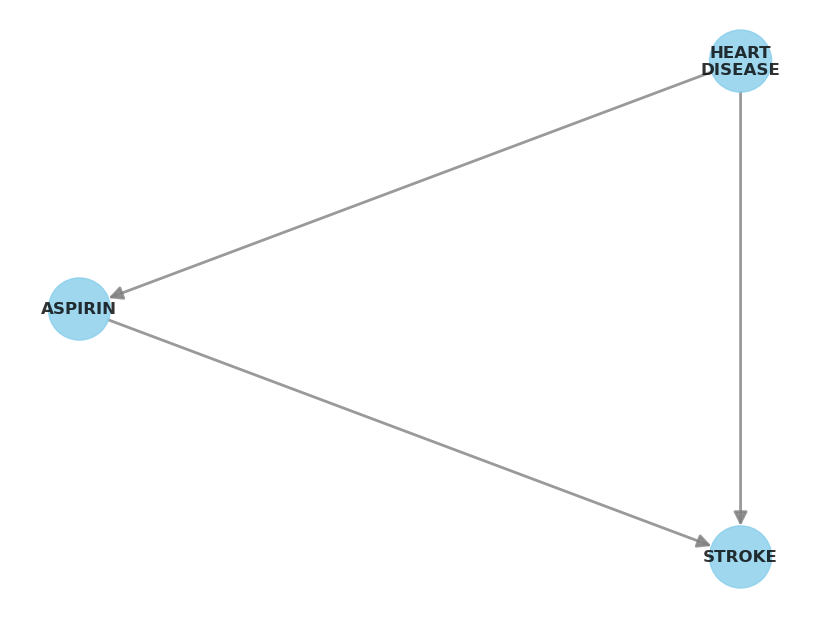

In [3]:
# Define the causal model
model = CausalModel(
    data=data,
    treatment='ASPIRIN',
    outcome='STROKE',
    common_causes=[ 'HEART DISEASE']
)
model.view_model(layout="dot")

## Causal discovery can be used when a  given dataset's causal structure is unknown

## Step 2: Identify the Target estimate

In [4]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                              
──────────(E[STROKE|HEART DISEASE])
d[ASPIRIN]                         
Estimand assumption 1, Unconfoundedness: If U→{ASPIRIN} and U→STROKE then P(STROKE|ASPIRIN,HEART DISEASE,U) = P(STROKE|ASPIRIN,HEART DISEASE)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Step 3 : Estimate the Causal Effect

In [5]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_matching")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                              
──────────(E[STROKE|HEART DISEASE])
d[ASPIRIN]                         
Estimand assumption 1, Unconfoundedness: If U→{ASPIRIN} and U→STROKE then P(STROKE|ASPIRIN,HEART DISEASE,U) = P(STROKE|ASPIRIN,HEART DISEASE)

## Realized estimand
b: STROKE~ASPIRIN+HEART DISEASE
Target units: ate

## Estimate
Mean value: -0.061



In [6]:
# Textual Interpreter
interpretation = estimate.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [ASPIRIN] from 0 to 1 causes an increase of -0.061 in the expected value of the outcome [['STROKE']], over the data distribution/population represented by the dataset.


In [7]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="att")
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                              
──────────(E[STROKE|HEART DISEASE])
d[ASPIRIN]                         
Estimand assumption 1, Unconfoundedness: If U→{ASPIRIN} and U→STROKE then P(STROKE|ASPIRIN,HEART DISEASE,U) = P(STROKE|ASPIRIN,HEART DISEASE)

## Realized estimand
b: STROKE~ASPIRIN+HEART DISEASE
Target units: att

## Estimate
Mean value: 0.02065887434247785

Causal Estimate is 0.02065887434247785


In [8]:
causal_estimate_ipw = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))
# Textual Interpreter
interpretation = causal_estimate_ipw.interpret(method_name="textual_effect_interpreter")

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                              
──────────(E[STROKE|HEART DISEASE])
d[ASPIRIN]                         
Estimand assumption 1, Unconfoundedness: If U→{ASPIRIN} and U→STROKE then P(STROKE|ASPIRIN,HEART DISEASE,U) = P(STROKE|ASPIRIN,HEART DISEASE)

## Realized estimand
b: STROKE~ASPIRIN+HEART DISEASE
Target units: ate

## Estimate
Mean value: 0.021666341752483054

Causal Estimate is 0.021666341752483054
Increasing the treatment variable(s) [ASPIRIN] from 0 to 1 causes an increase of 0.021666341752483054 in the expected value of the outcome [['STROKE']], over the data distribution/population represented by the dataset.


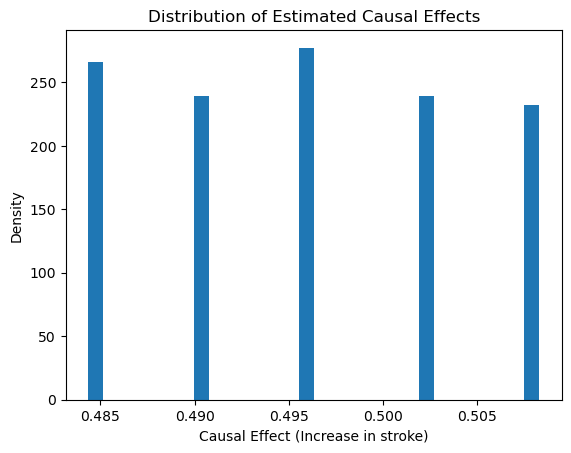

In [9]:
# Plotting the causal effect
plt.hist(causal_estimate_ipw.propensity_scores, bins=30, density=True)
plt.xlabel('Causal Effect (Increase in stroke)')
plt.ylabel('Density')
plt.title('Distribution of Estimated Causal Effects')
plt.show()


In [10]:
# Textual Interpreter
interpretation = causal_estimate_ipw.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [ASPIRIN] from 0 to 1 causes an increase of 0.021666341752483054 in the expected value of the outcome [['STROKE']], over the data distribution/population represented by the dataset.


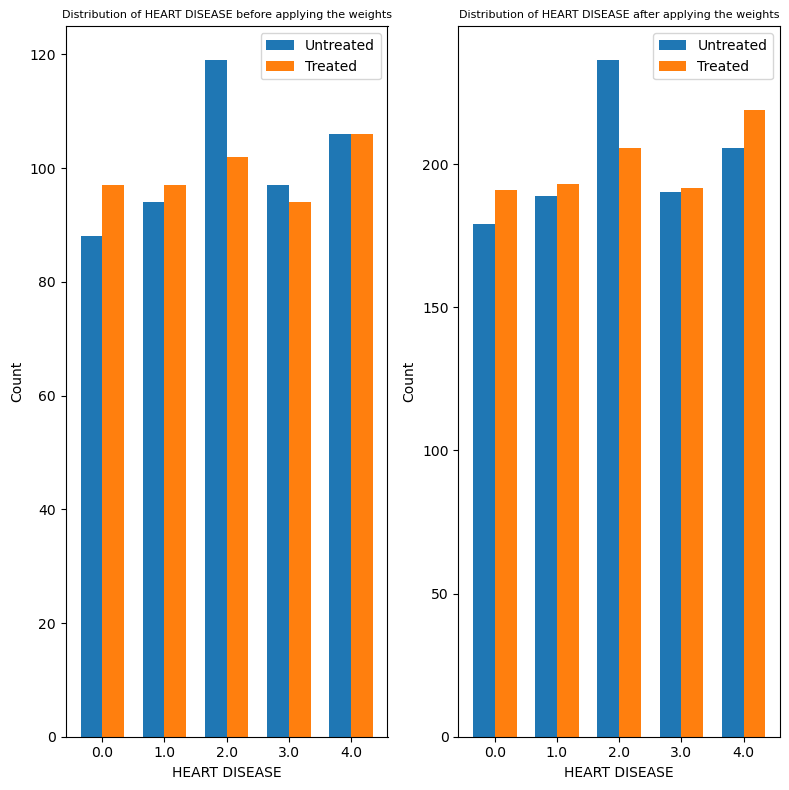

In [11]:
interpretation = causal_estimate_ipw.interpret(method_name="confounder_distribution_interpreter", 
                                               fig_size=(8,8), font_size=8, 
                                               var_name='HEART DISEASE', var_type='discrete')

## Step 4 Refute Estimate

In [12]:
# Step 4: Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(identified_estimand, estimate,
                                       method_name="random_common_cause")

In [13]:
print(refute_results)

Refute: Add a random common cause
Estimated effect:-0.061
New effect:-0.06099999999999998
p value:1.0



In [14]:
# Step 4: Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(identified_estimand, estimate,
                                       method_name="dummy_outcome_refuter")



In [15]:
print(refute_results[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.03832908045346368
p value:0.86



In [16]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
       method_name="placebo_treatment_refuter", show_progress_bar=True, placebo_type="permute")
print(res_placebo)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Use a Placebo Treatment
Estimated effect:-0.061
New effect:-0.0055499999999999985
p value:0.97

